In [1]:
# from synthetic import generate_synthetic_data
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from mlflux.utils import create_animation
from mlflux.synthetic import generate_synthetic_data
from mlflux.ann import sample_weights

### Generate 1D or 2D synthetic data

In [5]:
class FluxDataset(Dataset):
    def __init__(self, N=10000, choice='momentum'):
        
        # Generate data
        self.x1, self.x2, self.y1, self.y2 = generate_synthetic_data(N=N)
        self.X = torch.tensor(np.hstack([np.reshape(self.x1,(-1,1)),np.reshape(self.x2,(-1,1))]).astype('float32'))
        
        # A uniform grid flattened to make prediction maps
        # After making the prediction, Y_pred.reshape([100,100])
        x1_vis = np.linspace(0,20,100); x2_vis = np.linspace(-2,2,100)
        x1_mesh, x2_mesh = np.meshgrid(x1_vis,x2_vis,indexing='ij')
        X_uniform = np.hstack([np.reshape(x1_mesh,(-1,1)), np.reshape(x2_mesh,(-1,1))])
        self.X_uniform = torch.tensor(X_uniform.astype('float32'))
        
        # Choice y
        if choice == 'momentum':
            self.Y = torch.tensor(np.reshape(self.y1['sample'],(-1,1)).astype('float32'))
            self.min_MSE = np.average((self.y1['sample']-self.y1['mean'])**2)**0.5
        if choice == 'heat':
            self.Y = torch.tensor(np.reshape(self.y2['sample'],(-1,1)).astype('float32'))
            self.min_MSE = np.average((self.y2['sample']-self.y2['mean'])**2)**0.5
        
    def __len__(self):
        return len(self.x1)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    
class FluxDataset1D(Dataset):
    def __init__(self, N=10000, choice='momentum'):
        
        # Generate data
        self.x1, self.x2, self.y1, self.y2 = generate_synthetic_data(N=N)
        self.X = np.reshape(self.x1,(-1,1)).astype('float32')
        
        # A uniform grid flattened to make prediction maps
        # After making the prediction, Y_pred.reshape([100,100])
        x1_vis = np.linspace(0,20,100)
        X_uniform = np.reshape(x1_vis,(-1,1))
        self.X_uniform = torch.tensor(X_uniform.astype('float32'))
        
        # Choice y
        if choice == 'momentum':
            self.Y = torch.tensor(np.reshape(self.y1['sample'],(-1,1)).astype('float32'))
            self.min_MSE = np.average((self.y1['sample']-self.y1['mean'])**2)
        if choice == 'heat':
            self.Y = torch.tensor(np.reshape(self.y2['sample'],(-1,1)).astype('float32'))
            self.min_MSE = np.average((self.y2['sample']-self.y2['mean'])**2)
            
        # Weights?
        self.W = sample_weights(self.X)
        
    def __len__(self):
        return len(self.x1)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx], self.W[idx]

In [25]:
# dataset = FluxDataset(N=100000, choice='momentum')
dataset = FluxDataset1D(N=10000, choice='momentum')
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

In [26]:
from mlflux.ann import ANN
ann_para = {'n_in':1,'n_out':1,'hidden_channels':[16]}
mean_net = ANN(**ann_para)
var_net = ANN(**ann_para)

### Training mean and variance with log likelihood loss

In [31]:
''' Mean and variance networks trained on log likelihood simultaneously. '''

optimizer_joint = optim.Adam(list(var_net.parameters())+list(mean_net.parameters()), lr=1e-3)
# optimizer_joint = optim.Adam(var_net.parameters(), lr=1e-3)
num_epochs = 100
scheduler = optim.lr_scheduler.MultiStepLR(optimizer_joint, milestones=[int(num_epochs/2), int(num_epochs*3/4), int(num_epochs*7/8)], gamma=0.1)
log = {'LLLoss': [], 'var': [], 'mean': [], 'lr': []}

loss = nn.GaussianNLLLoss(reduction='none')

for epoch in range(num_epochs):
    LLLoss = 0.
    for i, (inputs, targets, w) in enumerate(dataloader):
        optimizer_joint.zero_grad()
        # Forward pass
        mean = mean_net(inputs)
        var = (var_net(inputs))**2 # squared to predict positive variance
        # likelihood = loss(targets, mean, var).mean()   
        likelihood = torch.sum(loss(targets, mean, var)*w)   
        # Backward and optimize (var and mean net)
        likelihood.backward() # TODO: Only need to call this once right?
        optimizer_joint.step()
        LLLoss += likelihood.item() * len(inputs)   
        
    scheduler.step()     

    LLLoss = LLLoss / len(dataset)
    var = (var_net(dataset.X_uniform))**2
    mean = mean_net(dataset.X_uniform)
    log['LLLoss'].append(LLLoss)
    log['var'].append(var.detach())
    log['mean'].append(mean.detach())
    log['lr'].append(scheduler.get_last_lr())
    
    # Print loss after every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {LLLoss:.8f}")

Epoch [1/100], Loss: -338.01735476
Epoch [2/100], Loss: -348.87418557
Epoch [3/100], Loss: -352.22691988
Epoch [4/100], Loss: -356.35218121
Epoch [5/100], Loss: -355.37633075
Epoch [6/100], Loss: -351.39572497
Epoch [7/100], Loss: -357.68144231
Epoch [8/100], Loss: -355.03955520
Epoch [9/100], Loss: -353.75693620
Epoch [10/100], Loss: -357.59633005
Epoch [11/100], Loss: -358.20350580
Epoch [12/100], Loss: -357.81469535
Epoch [13/100], Loss: -358.25108560
Epoch [14/100], Loss: -354.94212418
Epoch [15/100], Loss: -357.96215219
Epoch [16/100], Loss: -359.85023877
Epoch [17/100], Loss: -358.96694388
Epoch [18/100], Loss: -358.15099913
Epoch [19/100], Loss: -361.26879791
Epoch [20/100], Loss: -358.53459747
Epoch [21/100], Loss: -358.73365752
Epoch [22/100], Loss: -361.11089968
Epoch [23/100], Loss: -357.46427197
Epoch [24/100], Loss: -360.94980553
Epoch [25/100], Loss: -359.76897927
Epoch [26/100], Loss: -359.39211013
Epoch [27/100], Loss: -361.39029132
Epoch [28/100], Loss: -359.68918132
E

(0.0, 0.006)

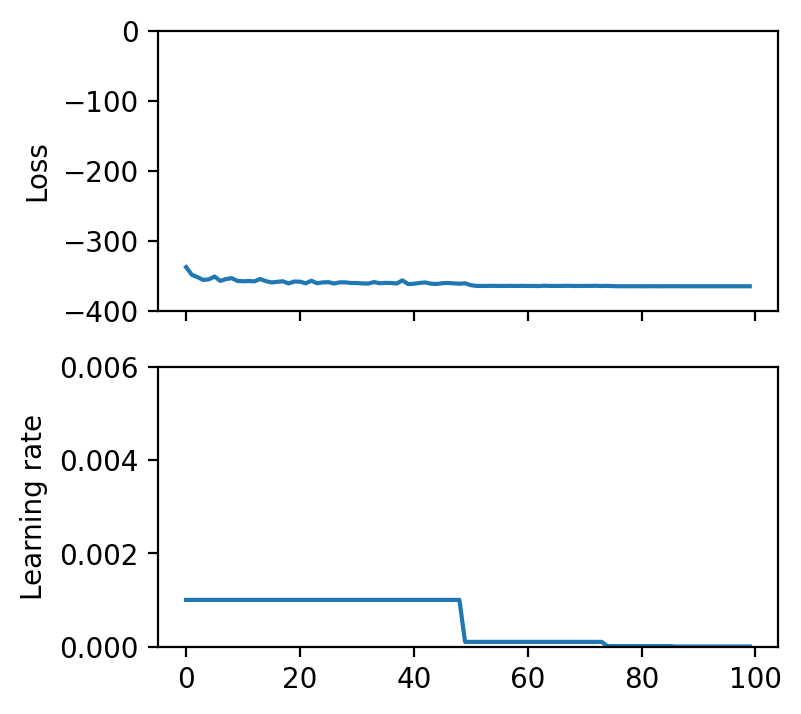

In [32]:
fig, axes = plt.subplots(2,1,sharex=True,figsize=[4,4],dpi=200)
axes[0].plot(log['LLLoss'])
axes[0].set_ylabel('Loss')
axes[0].set_ylim([-400,0])
axes[1].plot(log['lr'])
axes[1].set_ylabel('Learning rate')
axes[1].set_ylim([0,0.006])

### Generate animation showing training procedure
#### 1D case (lines)

In [33]:
def plot_epoch_1D(epoch=10):

    plt.figure(figsize=(4,4))
    plt.plot(dataset.X[:], dataset.Y[:], '.', markersize=0.5, label='training data')

    mean = log['mean'][epoch]
    std = np.sqrt(log['var'][epoch])

    mean_aver = mean; std_aver = std
    xplot = dataset.X_uniform
        
    plt.plot(xplot,mean_aver,'-', lw=1, color='k', label='Expectation')
    plt.plot(xplot,mean_aver-std_aver,'--', lw=1, color='k', label='$\pm \sigma$')
    plt.plot(xplot,mean_aver+std_aver,'--', lw=1, color='k')
        
    plt.xlim([0,20])
    plt.xticks([0,5,10,15,20])
    plt.ylim([0,0.8])
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.legend(loc='upper left', fontsize=12)
    plt.title('Prediction by ANN Epoch %g' %epoch)

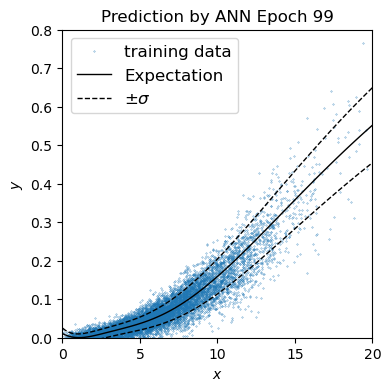

In [34]:
plot_epoch_1D(99)

In [155]:
create_animation(plot_epoch_1D, idx=np.arange(0,100,1), filename='figures/momentum_1D_Batch100_scheduler.gif', FPS=5)

Animation at FPS=5 will last for 20.0 seconds


#### 2D case (maps)

In [302]:
def plot_epoch_map(epoch=10):
    ''' Input:
            xaxis: the x axis variable to display. The prediction of the mean is then 
            averaged along the other dimensions. 0: wind speed; 1: temp diff. 
    '''
    plt.figure(figsize=(4,3))
    # plt.plot(dataset.X[:2000, xaxis], dataset.Y[:2000], '.', label='training \ndata')
    img = plt.pcolormesh(dataset.X_uniform[:,0].numpy().reshape(100,100), dataset.X_uniform[:,1].numpy().reshape(100,100),
                         log['mean'][epoch].reshape(100,100), vmax=1, vmin=0)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
#     plt.legend(loc='upper left', fontsize=12)
    plt.colorbar(img, ticks=[0,1])
    plt.title('Epoch %g' %epoch)

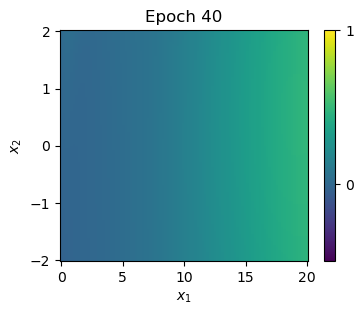

In [296]:
plot_epoch_map(40)

In [ ]:
create_animation(plot_epoch_map, idx=np.arange(0,50,1), filename='FluxUQ.gif', FPS=10)

In [ ]:
''' The truth, for comparison '''
plt.figure(figsize=(4,3), dpi=200)
X = dataset.X_uniform[:,0].numpy().reshape(100,100)
Y = dataset.X_uniform[:,1].numpy().reshape(100,100)
img = plt.pcolormesh(X, Y, 0.0015*X**2, vmax=1, vmin=0)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar(img, ticks=[0,1])
plt.title('True $\mu$')

### Older code

In [ ]:
''' Obsolete: train mean and then variance on MSE and then variance and mean on MLE ''' 
optimizer = optim.Adam(mean_net.parameters(), lr=1e-3)
num_epochs = 20
log = {'MSE': [], 'mean': []}
for epoch in range(num_epochs):
    MSE_loss = 0.
    for i, (inputs, targets) in enumerate(dataloader):
        # Forward pass
        mean = mean_net(inputs)
        MSE = ((mean-targets)**2).mean()

        # Backward and optimize
        optimizer.zero_grad()
        MSE.backward()
        optimizer.step()
        MSE_loss += MSE.item() * len(inputs)

    MSE_loss = MSE_loss / len(dataset)
    mean = mean_net(dataset.X_uniform)
    log['MSE'].append(MSE_loss)
    log['mean'].append(mean.detach())

    # Print loss after every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {MSE_loss:.4f}/{dataset.min_MSE:.4f}")
    
    
optimizer = optim.Adam(var_net.parameters(), lr=1e-3)
num_epochs = 30
log_var = {'MSE': [], 'var': []}
for epoch in range(num_epochs):
    MSE_loss = 0.
    for i, (inputs, targets) in enumerate(dataloader):
        # Forward pass
        mean = mean_net(inputs)
        r2 = (targets-mean)**2
        var = (var_net(inputs))**2 # squared to predict positive variance
        MSE = ((var-r2)**2).mean()

        # Backward and optimize
        optimizer.zero_grad()
        MSE.backward()
        optimizer.step()
        MSE_loss += MSE.item() * len(inputs)

    MSE_loss = MSE_loss / len(dataset)
    var = (var_net(dataset.X_uniform))**2
    log_var['MSE'].append(MSE_loss)
    log_var['var'].append(var.detach())

    # Print loss after every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {MSE_loss:.6f}")
    


In [ ]:
''' If we have more than 1 feature in input but want to visual along one input '''
def plot_epoch(epoch=10, xaxis=1):
    ''' Input:
            xaxis: the x axis variable to display. The prediction of the mean is then 
            averaged along the other dimensions. 0: wind speed; 1: temp diff. 
    '''
    plt.figure(figsize=(4,4))
    plt.plot(dataset.X[:2000, xaxis], dataset.Y[:2000], '.', label='training \ndata')

    mean = log['mean'][epoch]
    std = np.sqrt(log['var'][epoch])

    dims = [0,1] # for total dimension 2. TODO: refine it later
    dims.remove(xaxis) # axis except for the one specified
    mean_aver = np.average(mean.reshape(100,100), axis=tuple(dims)); std_aver = np.average(std.reshape(100,100), axis=tuple(dims))
    
    if xaxis == 0:
        xplot = dataset.X_uniform[:,xaxis].reshape(100,100)[0]
    elif xaxis == 1:
        xplot = dataset.X_uniform[:,xaxis].reshape(100,100)[:,0]
        
    plt.plot(xplot,mean_aver,'-', lw=1, color='k', label='Expectation')
    plt.plot(xplot,mean_aver-std_aver,'--', lw=1, color='k', label='$\pm \sigma$')
    plt.plot(xplot,mean_aver+std_aver,'--', lw=1, color='k')
        
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.legend(loc='upper left', fontsize=12)
    plt.title('Prediction by ANN')